In [145]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [143]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
import os
os.chdir(os.path.dirname("../"))

In [75]:
import deepof.data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from deepof.models import *
from scipy.optimize import curve_fit
from scipy.stats import linregress
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

# Tuning of latent space entropy radius

For

In [122]:
data_path = "../../Desktop/deepoftesttemp/"

In [123]:
# Load data and tag a few test videos
proj = deepof.data.project(path=data_path, arena_dims=[380]).run()
rules = proj.rule_based_annotation()
X_train, y_train, X_val, y_val = proj.get_coords(propagate_annotations=False).preprocess(test_videos=0)

Loading trajectories...
Smoothing trajectories...
Interpolating outliers...
Iterative imputation of ocluded bodyparts...
Computing distances...


  0%|          | 0/2 [00:00<?, ?it/s]

Computing angles...
Done!


100%|██████████| 2/2 [00:06<00:00,  3.00s/it]


In [124]:
#Load the models, and try different radii 

# each dataset is rank 3: encoding dimensions, number of clusters, and different radii 
x, y = np.zeros([6, 6, 100]), np.zeros([6, 6, 100])

# Iterate over encoding dimensions
for a,d in enumerate(tqdm((2, 4, 6, 8, 10, 12))):
    
    for b, k in enumerate(tqdm((1,5,10,15,20,25))):

        gmvaep = SEQ_2_SEQ_GMVAE(encoding=d, number_of_components=k).build(X_train.shape)[3]
        # Get encoer and grouper from full model
        cluster_means = [
            layer for layer in gmvaep.layers if layer.name == "latent_distribution"
        ][0]
        cluster_assignment = [
            layer for layer in gmvaep.layers if layer.name == "cluster_assignment"
        ][0]

        encoder = tf.keras.models.Model(
            gmvaep.layers[0].input, cluster_means.output
        )
        grouper = tf.keras.models.Model(
            gmvaep.layers[0].input, cluster_assignment.output
        )

        # Use encoder and grouper to predict on validation data
        encoding = encoder.predict(X_train)
        groups = grouper.predict(X_train)

        pdist = pairwise_distances(encoding)

        for i, r in enumerate(np.linspace(0, 5, 100)):
            x[a][b][i], y[a][b][i] = np.round(r, 7), np.median(np.sum(pdist < r, axis=0))

100%|██████████| 6/6 [1:28:48<00:00, 888.11s/it]


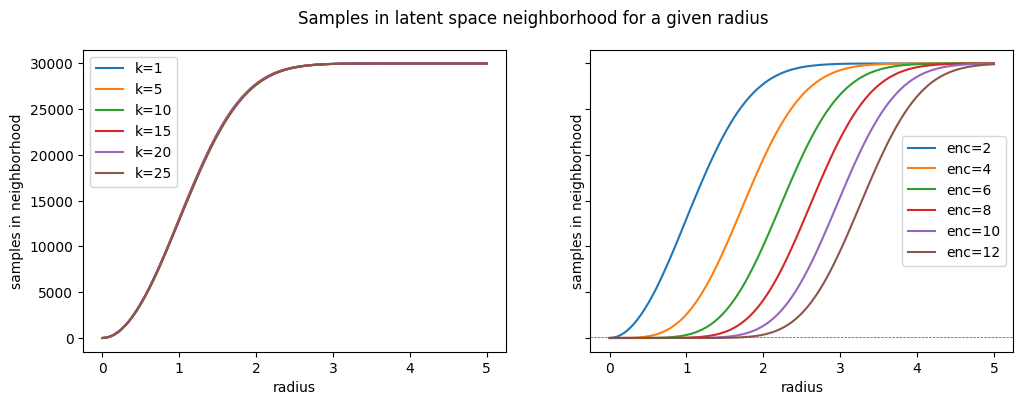

In [158]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k', sharey=True)

plt.suptitle("Samples in latent space neighborhood for a given radius")

# Plot number of neighbors in radius versus number of clusters
for i,k in enumerate([1,5,10,15,20,25]):
    ax1.plot(x[0][i], y[0][i], label="k={}".format(k))
    
# Plot number of neighbors in radius versus encoding dimensions
for i,d in enumerate([2,4,6,8,10,12]):
    ax2.plot(x[i][3], y[i][3], label="enc={}".format(d))

ax1.set_xlabel("radius")
ax1.set_ylabel("samples in neighborhood")
ax1.legend()

ax2.set_xlabel("radius")
ax2.set_ylabel("samples in neighborhood")
ax2.axhline(100, linestyle="--", c="r", linewidth=0.5)
ax2.legend()

plt.show()

In [126]:
# Fit sigmoid functions to the data in the second plot, and compute the radius that yields K neighbors in average for
# each curve
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

def fit_sigmoid(x, y):
    p0 = [max(y), np.median(x),1,min(y)]
    popt, pcov = curve_fit(sigmoid, x, y, p0, method='dogbox')
    return popt

def retrieve_x_from_sigmoid(x, y, n):
    L, x0, k, b = fit_sigmoid(x, y)
    x_given_k = - ( np.log( L/( n-b )-1 ) / k ) + x0
    return x_given_k

In [127]:
n = 100
x_given_n = np.zeros(6)
y_given_n = np.array([2,4,6,8,10,12])

for i in range(6):
    x_given_n[i] = retrieve_x_from_sigmoid(x[i][0], y[i][0], n)

In [128]:
# Fit a line to the data to get an equation of how #neighbors varies with encoding dimensions
# The retrieved equation will be the default radius!
res = linregress(y_given_n, x_given_n)
res

LinregressResult(slope=0.14930984919003817, intercept=-0.18229558922163147, rvalue=0.9994896901980332, pvalue=3.9055769453235144e-07, stderr=0.002385924419741199)

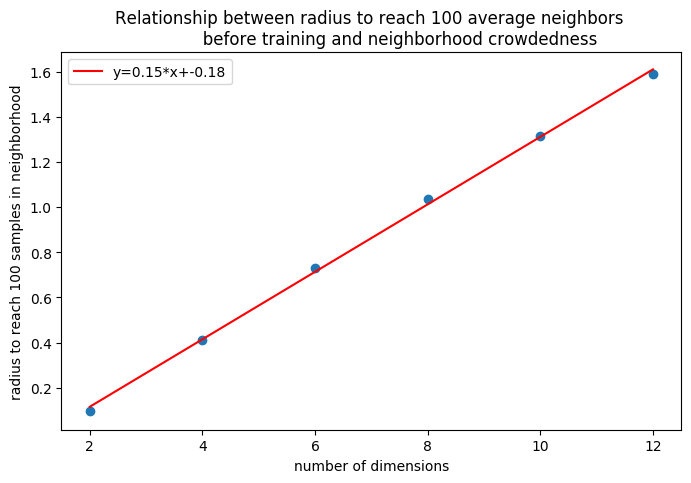

In [166]:
fig = plt.figure(figsize=(8,5), dpi= 100, facecolor='w', edgecolor='k')

plt.scatter(y_given_n, x_given_n)
plt.plot(y_given_n, res.intercept + res.slope*y_given_n, 'r', 
         label='y={}*x+{}'.format(np.round(res.slope,2), np.round(res.intercept,2)))

plt.title("Relationship between radius to reach {} average neighbors \n \
          before training and neighborhood crowdedness".format(n))
plt.ylabel("radius to reach {} samples in neighborhood".format(n))
plt.xlabel("number of dimensions")
plt.legend()
plt.show()